# Part 3: Train and register a machine learning model

In this tutorial, you'll learn to train multiple machine learning models to select the best one in order to predict which bank customers are likely to leave.

Once a model is trained, you'll register the trained model, and log the used hyperaparameters as well as the evaluation metrics using Microsoft Fabric's native integration with the MLflow framework.

[MLflow](https://mlflow.org/docs/latest/index.html) is an open source platform for managing the machine learning lifecycle with features like Tracking, Models, and Model Registry. MLflow is natively integrated with the Fabric Data Science experience.


## Doing some install custom libraries

For this notebook, you'll install imbalanced-learn (imported as `imblearn`) using `%pip install`. Imbalanced-learn is a library for Synthetic Minority Oversampling Technique (SMOTE) which is used when dealing with imbalanced datasets. The PySpark kernel will be restarted after `%pip install`, so you'll need to install the library before you run any other cells. 

You'll access SMOTE using the `imblearn` library. Install it now using the in-line installation capabilities (e.g., `%pip`, `%conda`).



In [1]:
# Install imblearn for SMOTE using pip
%pip install imblearn

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 8, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 14.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.




## Load the data

Load the delta table from the lakehouse in order to read the cleaned data you created in the previous notebook.

In [2]:
import pandas as pd
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 10, Finished, Available, Finished)

### Generate experiment for tracking and logging the model using MLflow

This section demonstrates how to generate an experiment, specify model and training parameters as well as scoring metrics, train the models, log them, and save the trained models for later use.

In [3]:
import mlflow
# Setup experiment name
EXPERIMENT_NAME = "bank-churn-experiment"  # MLflow experiment name

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 11, Finished, Available, Finished)

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. 

All the experiments with their respective names are logged and you'll be able to track their parameters and performance metrics. To learn more about  autologging, see  [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

### Set experiment and autologging specifications

In [4]:
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(exclusive=False)

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 12, Finished, Available, Finished)

## Import scikit-learn and LightGBM

With your data in place, you can now define the machine learning models. You'll apply Random Forrest and LightGBM models in this notebook. Use `scikit-learn` and `lightgbm` to implement the models within a few lines of code. 

This step should be fast - cca 10sec on default workspace and TK-environment

In [5]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 13, Finished, Available, Finished)

2024/10/25 11:31:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/25 11:31:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


## Prepare training, validation and test datasets

Use the `train_test_split` function from `scikit-learn` to split the data into training and test sets.

In [6]:
y = df_clean["Exited"]
X = df_clean.drop("Exited",axis=1)
# Split the dataset to 60%, 20%, 20% for training, validation, and test datasets
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
# Train-Validation Separation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)


StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 14, Finished, Available, Finished)

### Save test data to a delta table

Save the test data to the delta table for use in the next notebook.

In [7]:
table_name = "df_test"
# Create PySpark DataFrame from Pandas
df_test=spark.createDataFrame(X_test)
df_test.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark test DataFrame saved to delta table: {table_name}")

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 15, Finished, Available, Finished)

Spark test DataFrame saved to delta table: df_test



### Apply SMOTE to the training data to synthesize new samples for the minority class

The data exploration in part 2 showed that out of the 10,000 data points corresponding to 10,000 customers, only 2,037 customers (around 20%) have left the bank. This indicates that the dataset is highly imbalanced. The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. SMOTE is the most widely used approach to synthesize new samples for the minority class. Learn more about SMOTE [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [here](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn).

> [!TIP]
>
> Note that SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the machine learning model will perform on the original data, which is representing the situation in production.


In [8]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 16, Finished, Available, Finished)

2024/10/25 11:32:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f3517a6-6f31-49a8-9a05-65dd74caff4d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-10-25:11:32:30,372 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/25 11:32:31 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/10/25 11:32:31 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/10/25 11:32:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/25 11:32:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/ho

### Model Training

RF -4-4 => 20 sec

RF -6-8 =>

LightGBM => 20 sec

* Train the model using Random Forest with maximum depth of 4 and 4 features

In [9]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm') # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # Imbalanaced training data
    rfc1_sm.fit(X_res, y_res.ravel()) # Balanced training data
    rfc1_sm.score(X_val, y_val)
    y_pred = rfc1_sm.predict(X_val)
    cr_rfc1_sm = classification_report(y_val, y_pred)
    cm_rfc1_sm = confusion_matrix(y_val, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 17, Finished, Available, Finished)

2024/10/25 11:32:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-10-25:11:32:54,148 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/25 11:32:56 WARNING mlf

run_id: cba14689-795a-4737-8984-881455206f0d; status: RUNNING


* Train the model using Random Forest with maximum depth of 8 and 6 features

In [10]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm') # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # Imbalanced training data
    rfc2_sm.fit(X_res, y_res.ravel()) # Balanced training data
    rfc2_sm.score(X_val, y_val)
    y_pred = rfc2_sm.predict(X_val)
    cr_rfc2_sm = classification_report(y_val, y_pred)
    cm_rfc2_sm = confusion_matrix(y_val, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 18, Finished, Available, Finished)

2024/10/25 11:33:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-10-25:11:33:21,751 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/25 11:33:24 WARNING mlf

run_id: 34d59779-0309-46d3-afd8-210eb0bf050d; status: RUNNING


* Train the model using LightGBM

In [11]:
# lgbm_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm') # Register the trained model with autologging
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        eval_metric = "logloss", 
                        objective='binary', 
                        random_state=42)

with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    # lgbm_sm_model.fit(X_train,y_train) # Imbalanced training data
    lgbm_sm_model.fit(X_res, y_res.ravel()) # Balanced training data
    y_pred = lgbm_sm_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    cr_lgbm_sm = classification_report(y_val, y_pred)
    cm_lgbm_sm = confusion_matrix(y_val, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

StatementMeta(, 61d0e429-65ba-493f-b4ef-aac2b4589fa8, 19, Finished, Available, Finished)

2024/10/25 04:30:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-10-25:04:30:03,422 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/25 04:30:04 WARNING mlf

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4754, number of negative: 4754
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 9508, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leav

## Experiments artifact for tracking model performance

The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. They're named based on the name used for setting the experiment. All of the trained models, their runs, performance metrics and model parameters are logged. 

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _bank-churn-experiment_. If you don't see the experiment in your workspace, refresh your browser.

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/experiment_runs.png"  width="400%" height="100%" title="Screenshot shows logged values for one of the models.">

#### Assess the performances of the trained models on the validation dataset

Once done with machine learning model training, you can assess the performance of trained models in two ways.

- Open the saved experiment from the workspace, load the machine learning models, and then assess the performance of the loaded models on the validation dataset.

In [11]:
# Define run_uri to fetch the model
# mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")
# Assess the performance of the loaded model on validation dataset
ypred_rfc1_sm_v1 = load_model_rfc1_sm.predict(X_val) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm_v1 = load_model_rfc2_sm.predict(X_val) # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm_v1 = load_model_lgbm1_sm.predict(X_val) # LightGBM

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 19, Finished, Available, Finished)

NameError: name 'lgbm1_sm_run_id' is not defined

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 20, Finished, Available, Finished)

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 21, Finished, Available, Finished)

- Directly assess the performance of the trained machine learning models on the validation dataset.

In [13]:
ypred_rfc1_sm_v2 = rfc1_sm.predict(X_val) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm_v2 = rfc2_sm.predict(X_val) # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm_v2 = lgbm_sm_model.predict(X_val) # LightGBM

StatementMeta(, 61d0e429-65ba-493f-b4ef-aac2b4589fa8, 24, Finished, Available, Finished)

2024/10/25 04:32:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-10-25:04:32:34,940 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/25 04:32:35 WARNING mlf

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Depending on user's preference, either approach is fine and should offer identical performances. In this notebook, you'll choose the first approach in order to better demonstrate the MLflow autologging capabilities in Microsoft Fabric.

 #### Show True/False Positives/Negatives using the Confusion Matrix

Next, you'll develop a script to plot the confusion matrix in order to evaluate the accuracy of the classification using the validation dataset. The confusion matrix can be plotted using SynapseML tools as well, which is shown in Fraud Detection sample that is available [here](https://aka.ms/samples/frauddectection).

In [12]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, 65402fb9-ceff-49a5-93c2-e42eb8eba307, 22, Finished, Available, Finished)

2024/10/25 11:35:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


* Confusion Matrix for Random Forest Classifier with maximum depth of 4 and 4 features

StatementMeta(, 61d0e429-65ba-493f-b4ef-aac2b4589fa8, 26, Finished, Available, Finished)

[[1365  231]
 [ 157  247]]


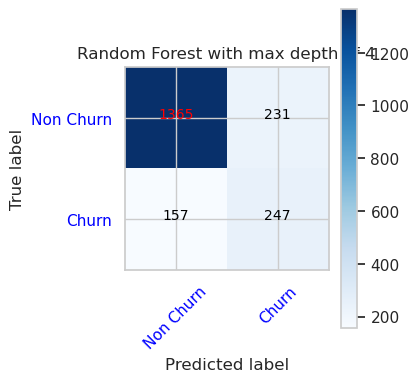

In [15]:
cfm = confusion_matrix(y_val, y_pred=ypred_rfc1_sm_v1)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

* Confusion Matrix for Random Forest Classifier with maximum depth of 8 and 6 features

StatementMeta(, 61d0e429-65ba-493f-b4ef-aac2b4589fa8, 27, Finished, Available, Finished)

[[1427  169]
 [ 175  229]]


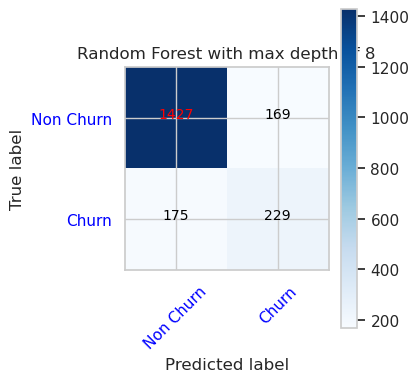

In [16]:
cfm = confusion_matrix(y_val, y_pred=ypred_rfc2_sm_v1)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

* Confusion Matrix for LightGBM

StatementMeta(, 61d0e429-65ba-493f-b4ef-aac2b4589fa8, 28, Finished, Available, Finished)

[[1485  111]
 [ 189  215]]


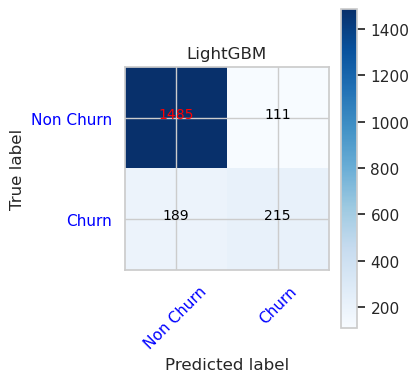

In [17]:
cfm = confusion_matrix(y_val, y_pred=ypred_lgbm1_sm_v1)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

## Next step

GoTO: "Part 4: Perform batch scoring and save predictions to a lakehouse"